# Dimensionality Reduction

## Learning outcomes
**After having completed this chapter you will be able to:**

- Understand the differences between PCA and UMAP
- Perform PCA and select a reasonable number of components for downstream UMAP embeddings
- Visualize the contribution of different genes to each principal component

In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

<button onclick="toggleVisibility('answer0')">Click for Answer</button>
<div id="answer0" style="display:none;">
<strong>Answer:</strong> Load your data from the previous notebook into an h5ad object with <code>sc.read_h5ad</code>
<pre>
    adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial2.h5ad")
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

## Principal component analysis

Dimensionality reduction methods seek to take a large set of variables and return a smaller set of components that still contain most of the information in the original dataset. One of the simplest forms of dimensionality reduction is PCA. Principal component analysis (PCA) is a mathematical procedure that transforms a number of possibly correlated (e.g., expression of genes in a network) variables into a (smaller) number of uncorrelated variables called principal components ("PCs").

**Exercise 1**: Run PCA analysis using `sc.pp.pca` in scanpy using `n_comps=50`. Plot a scatter plot of the first two principal components with `sc.pl.pca`, which should capture the largest axes of variability in the data.

<button onclick="toggleVisibility('answer1')">Click for Answer</button>
<div id="answer1" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.pp.pca(adata, svd_solver="arpack", n_comps=50)
    sc.pl.pca(adata, color="sample")
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

**Exercise 2:** We can color the PCA plot according to any factor that is present in `adata.obs`, or for any gene's expression. Can you `color` by the column `n_counts` and `phase`? What about by the genes `HBA1` (an alpha subunit of hemoglobin) `IGKC` (one of the most highly variable genes)?

<button onclick="toggleVisibility('answer2')">Click for Answer</button>
<div id="answer2" style="display:none;">
<strong>Answer:</strong>
<pre>
    # visualize the first PCs, color by cell cycle phase and n_counts (unnormalized)
    sc.pl.pca_scatter(adata, color=["n_counts", "phase"])
    sc.pl.pca_scatter(adata, color=["HBA1", "IGKC"])
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

Each principal component scores the contribution of each gene to that component. Therefore, we can see which genes are more highly correlated to one component compared to the others. You can see that there are certain biases in the data due to the cell cycle phase and n_counts.

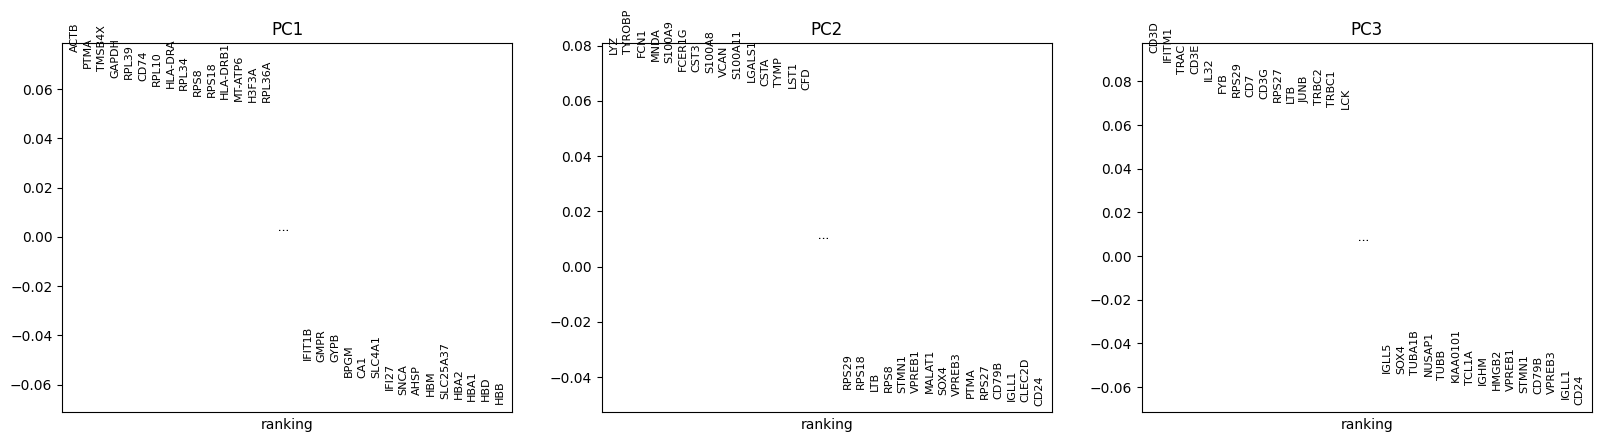

In [4]:
sc.pl.pca_loadings(adata, components = '1,2,3')

Since PCA is a geometric form of dimensionality reduction, we can visualize the specific genes that most strongly contribute to each principal component. This allows us to get an idea of which components discriminate which cells from each other.

In [5]:
def pca_heatmap(adata, component, groupby, use_raw=False, layer=None):
    attr = 'varm'
    keys = 'PCs'
    scores = getattr(adata, attr)[keys][:, component]
    dd = pd.DataFrame(scores, index=adata.var_names)
    var_names_pos = dd.sort_values(0, ascending=False).index[:20]

    var_names_neg = dd.sort_values(0, ascending=True).index[:20]

    pd2 = pd.DataFrame(adata.obsm['X_pca'][:, component], index=adata.obs.index)

    bottom_cells = pd2.sort_values(0).index[:300].tolist()
    top_cells = pd2.sort_values(0, ascending=False).index[:300].tolist()

    sc.pl.heatmap(adata[top_cells+bottom_cells], list(var_names_pos) + list(var_names_neg), 
                        show_gene_labels=True, groupby=groupby,
                        swap_axes=True, cmap='viridis', 
                        use_raw=use_raw, layer=layer, figsize=(6,4))

**Exercise 3:** Use the `pca_heatmap` function defined above to plot the PC1 and PC2 components. Group the top/bottom cells by their `sample` identifier?

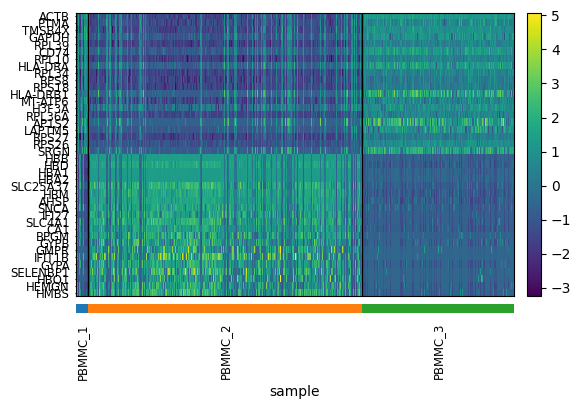

In [6]:
pca_heatmap(adata, component=0, groupby="sample")

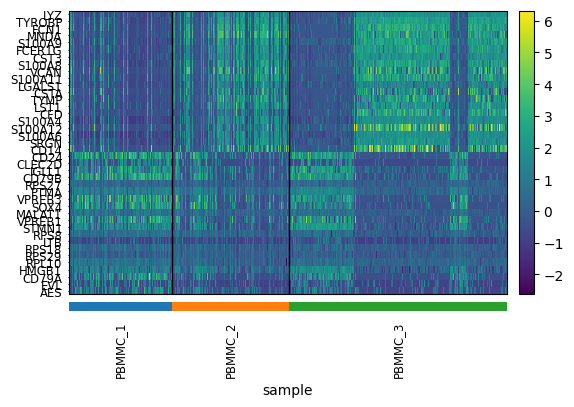

In [7]:
pca_heatmap(adata, component=1, groupby="sample")

**Exercise 4:** Do you see anything strange about these results? Is there something undesirable about the way in which the PCs discriminate cell populations that might not be biological?

<button onclick="toggleVisibility('answer4')">Click for Answer</button>
<div id="answer4" style="display:none;">
<strong>Answer:</strong> Yes! The first principal component (PC1) seems to separate cells according to their sample, which may not be biological but rather a batch effect. For example, the genes most commonly associated with a positive value for PC1 are most highly expressed in PBMMC-3 and not PBMMC-1 or PBMMC-2. Conversely, the genes most commonly associated with a negative value for PC1 are most highly expressed in PBMMC-1 and PBMMC-2 but not PBMMC-3.


<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

For further dimensionality reduction, we need to select a number of PCs to use (the rest are excluded). Ideally, we want to capture as much data variance as possible in as few PCs as possible. The plot generated with `pca_variance_ratio` can help you in determining how many PCs to use for downstream analysis such as UMAP:

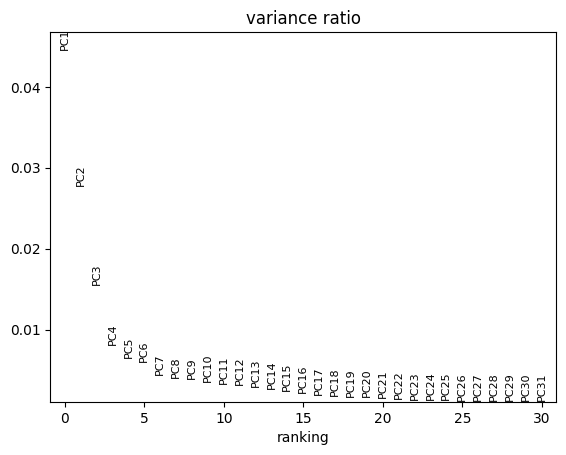

In [8]:
sc.pl.pca_variance_ratio(adata, log=False) # see contribution of each PC to variance

This plot ranks principle components based on the percentage of variance explained by each one. Where we observe an “elbow” or flattening curve, the majority of true signal is captured by this number of PCs.

Including too many PCs usually does not affect much the result, while including too few PCs can affect the results very much

Another - maybe more intuitive - way to see it, is to use a cumulative sum to show the % unexplained variance in function of the number of PCs. If we look at the first PCs, we can see that we passed the elbow with 30 to 50 PCs, which should ensure that we capture the major part of the variability in our dataset to be shown on a 2D representation like UMAP or tSNE.

Text(0.5, 0, 'N PCs')

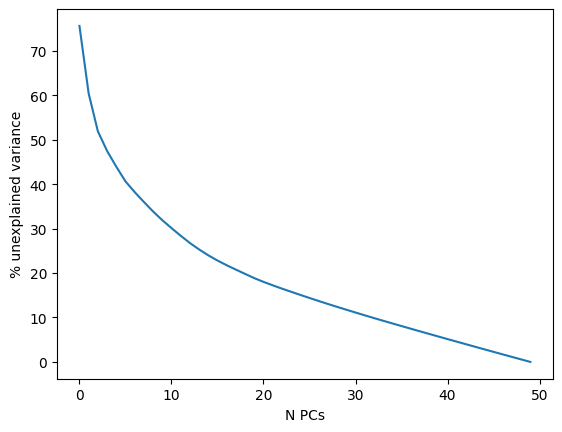

In [9]:
plt.plot(100 - (np.cumsum(adata.uns["pca"]["variance_ratio"])*100)/sum(adata.uns["pca"]["variance_ratio"]))
plt.ylabel('% unexplained variance') ; plt.xlabel('N PCs')

## Dimensionality reduction

**Exercise 5:** Compute the neighborhood graph of cells using the PCA representation of the data matrix. The purpose of this step is to understand the “distance” between individual cells in the lower-dimensional PCA space, important for creating 2D scatter plot representations of your data. The number of neighbors used will influence how much the data is smoothened, which is a necessary step due to the sparsity (missing values) widely present in scRNA-seq data compared to bulk methods. Use the `sc.pp.neighbors` function and a number of components chosen based on the pca_variance_ratio and cumulative sum plots above.

<button onclick="toggleVisibility('answer5')">Click for Answer</button>
<div id="answer5" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.pp.neighbors(adata, n_pcs = 30) # specify the number of neighbors and number of PCs you wish to use
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

Embedding the graph in a 2D representation can be performed using either tSNE or UMAP algorithms.

**Exercise 6**: Run tSNE and UMAP algorithms on your data after completing the previous steps with default parameters. We will evaluate the quality of each approach in later exercises.

<button onclick="toggleVisibility('answer6')">Click for Answer</button>
<div id="answer6" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.tl.tsne(adata)
    sc.tl.umap(adata)
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

To view the UMAP plot: 

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


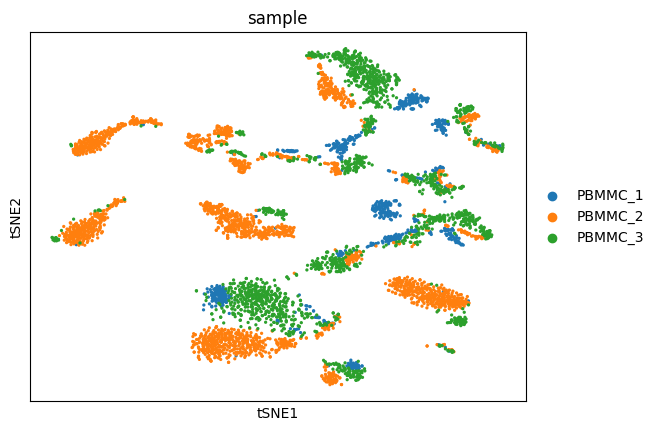

In [12]:
sc.pl.tsne(adata, color=["sample"])

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


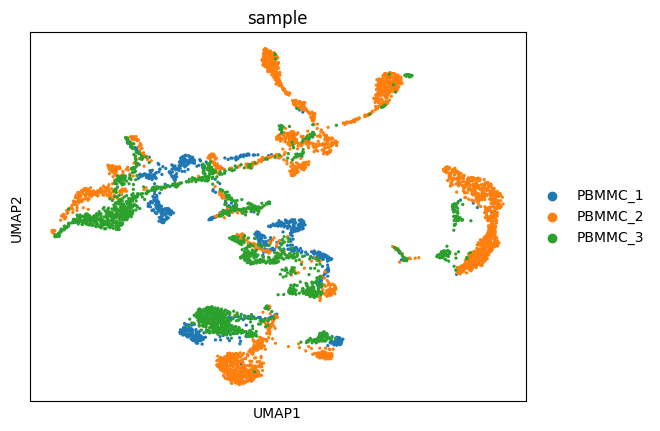

In [13]:
sc.pl.umap(adata, color=["sample"])

**Exercise 7**: Try out the following:

A. Color the dots in the UMAP according to a variable (e.g. `n_counts` or `HBA1`). Any idea where the erythrocytes probably are in the UMAP?

B. Change the number of neighbors used for the calculation of the UMAP. Which is the parameter to change and how did it affect the output. What is the default? In which situation would you lower/increase this?

C. Change the number of principal components (n_pcs) to extremely few (5) or many (50). How does this it affect the output? In your opinion, it is better with fewer or more PCs? Why does n_pcs=150 not work? When would more precision be needed?

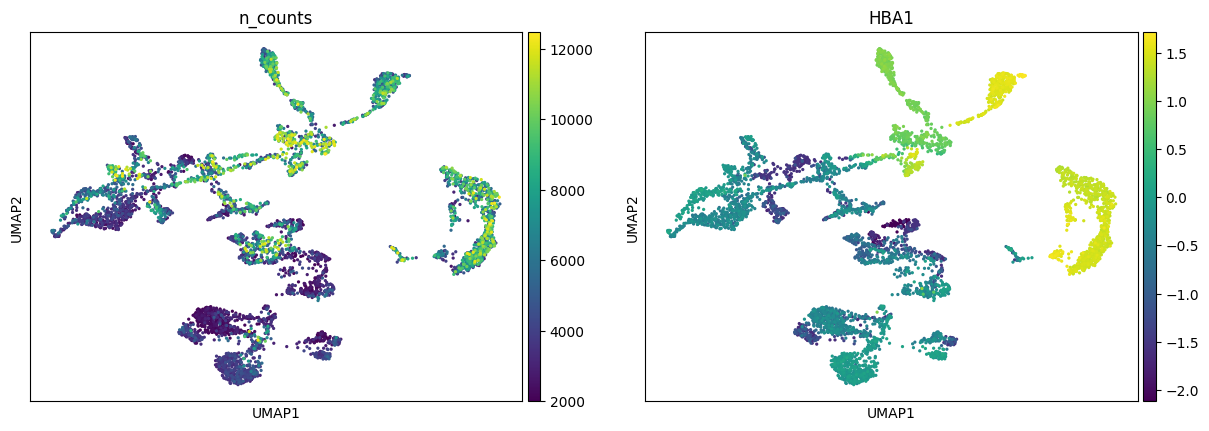

In [14]:
sc.pl.umap(adata, color=["n_counts", "HBA1"])

**Exercise 8**: What do you think is the main problem with this low dimensional embeddings - do they capture the expected variance in the dataset?

<button onclick="toggleVisibility('answer8')">Click for Answer</button>
<div id="answer8" style="display:none;">
<strong>Answer:</strong> The biggest problem appears to be that there is a strong batch effect. Different regions of the UMAP and tSNE are both occupied by cells belonging to a single sample.
    
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> 
</div>

Save your results!

In [15]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial3.h5ad")